# Task 1: Data Exploration
## Forecasting Financial Inclusion in Ethiopia

**Objective:** Understand the structure and content of the dataset to prepare for forecasting.

**Key Questions:**
- What is the structure of the unified data schema?
- What observations, events, and impact links exist?
- How complete and reliable is the data?
- What patterns and trends are visible?

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d')}")

✓ Libraries imported successfully
Analysis Date: 2026-01-28


## 1. Load and Understand the Schema

In [22]:
# Define file paths
data_path = '../data/raw/ethiopia_fi_unified_data.xlsx'
reference_path = '../data/raw/reference_codes.xlsx'
guide_path = '../data/raw/Additional Data Points Guide.xlsx'

# First, check what sheets are available
print("Checking available sheets...")
excel_file = pd.ExcelFile(data_path)
print(f"Available sheets in data file: {excel_file.sheet_names}")

# Load the main dataset - adjust based on available sheets
print("\nLoading unified dataset...")
# If there's a 'data' sheet, use it; otherwise use the first sheet
if 'data' in excel_file.sheet_names:
    df_data = pd.read_excel(data_path, sheet_name='data')
    df_impact = pd.read_excel(data_path, sheet_name='impact_links')
else:
    # Load the first sheet as data
    df_data = pd.read_excel(data_path, sheet_name=0)
    # Check if there's a second sheet for impact links
    if len(excel_file.sheet_names) > 1:
        df_impact = pd.read_excel(data_path, sheet_name=1)
    else:
        # Filter impact links from the same sheet
        df_impact = df_data[df_data['record_type'] == 'impact_link'].copy()

print(f"\n✓ Data sheet loaded: {df_data.shape[0]} records")
print(f"✓ Impact links loaded: {df_impact.shape[0]} records")

# Load reference codes
df_reference = pd.read_excel(reference_path)
print(f"✓ Reference codes loaded: {df_reference.shape[0]} codes")

# Display schema structure
print("\n" + "="*80)
print("DATASET COLUMNS")
print("="*80)
print("\nData sheet columns:")
for i, col in enumerate(df_data.columns, 1):
    print(f"{i:2d}. {col}")

Checking available sheets...
Available sheets in data file: ['ethiopia_fi_unified_data', 'Impact_sheet']

Loading unified dataset...

✓ Data sheet loaded: 43 records
✓ Impact links loaded: 14 records
✓ Reference codes loaded: 71 codes

DATASET COLUMNS

Data sheet columns:
 1. record_id
 2. record_type
 3. category
 4. pillar
 5. indicator
 6. indicator_code
 7. indicator_direction
 8. value_numeric
 9. value_text
10. value_type
11. unit
12. observation_date
13. period_start
14. period_end
15. fiscal_year
16. gender
17. location
18. region
19. source_name
20. source_type
21. source_url
22. confidence
23. related_indicator
24. relationship_type
25. impact_direction
26. impact_magnitude
27. impact_estimate
28. lag_months
29. evidence_basis
30. comparable_country
31. collected_by
32. collection_date
33. original_text
34. notes


In [23]:
# Examine the unified schema design
print("UNIFIED SCHEMA DESIGN")
print("="*80)
print("\nRecord Type Distribution:")
print(df_data['record_type'].value_counts())

print("\n" + "-"*80)
print("KEY PRINCIPLE: Events are NOT pre-assigned to pillars")
print("-"*80)
print("\n✓ Observations have pillar assignments (what dimension is measured)")
print("✓ Events have category (type of event) but NO pillar")
print("✓ Impact links connect events to indicators via pillar")
print("\nThis prevents interpretation bias in the data.")

UNIFIED SCHEMA DESIGN

Record Type Distribution:
record_type
observation    30
event          10
target          3
Name: count, dtype: int64

--------------------------------------------------------------------------------
KEY PRINCIPLE: Events are NOT pre-assigned to pillars
--------------------------------------------------------------------------------

✓ Observations have pillar assignments (what dimension is measured)
✓ Events have category (type of event) but NO pillar
✓ Impact links connect events to indicators via pillar

This prevents interpretation bias in the data.


## 2. Explore Observations

In [24]:
# Filter observations
observations = df_data[df_data['record_type'] == 'observation'].copy()

print(f"Total Observations: {len(observations)}")
print("\n" + "="*80)
print("OBSERVATIONS BY PILLAR")
print("="*80)
print(observations['pillar'].value_counts())

print("\n" + "="*80)
print("OBSERVATIONS BY INDICATOR")
print("="*80)
print(observations.groupby(['pillar', 'indicator_code']).size())

print("\n" + "="*80)
print("TEMPORAL COVERAGE")
print("="*80)
observations['observation_date'] = pd.to_datetime(observations['observation_date'])
print(f"Date Range: {observations['observation_date'].min()} to {observations['observation_date'].max()}")
print(f"\nObservations by Year:")
print(observations['observation_date'].dt.year.value_counts().sort_index())

Total Observations: 30

OBSERVATIONS BY PILLAR
pillar
ACCESS           14
USAGE            11
GENDER            4
AFFORDABILITY     1
Name: count, dtype: int64

OBSERVATIONS BY INDICATOR
pillar         indicator_code    
ACCESS         ACC_4G_COV            2
               ACC_FAYDA             3
               ACC_MM_ACCOUNT        2
               ACC_MOBILE_PEN        1
               ACC_OWNERSHIP         6
AFFORDABILITY  AFF_DATA_INCOME       1
GENDER         GEN_GAP_ACC           2
               GEN_GAP_MOBILE        1
               GEN_MM_SHARE          1
USAGE          USG_ACTIVE_RATE       1
               USG_ATM_COUNT         1
               USG_ATM_VALUE         1
               USG_CROSSOVER         1
               USG_MPESA_ACTIVE      1
               USG_MPESA_USERS       1
               USG_P2P_COUNT         2
               USG_P2P_VALUE         1
               USG_TELEBIRR_USERS    1
               USG_TELEBIRR_VALUE    1
dtype: int64

TEMPORAL COVERAGE
Date R


✓ Visualization saved: observations_overview.png


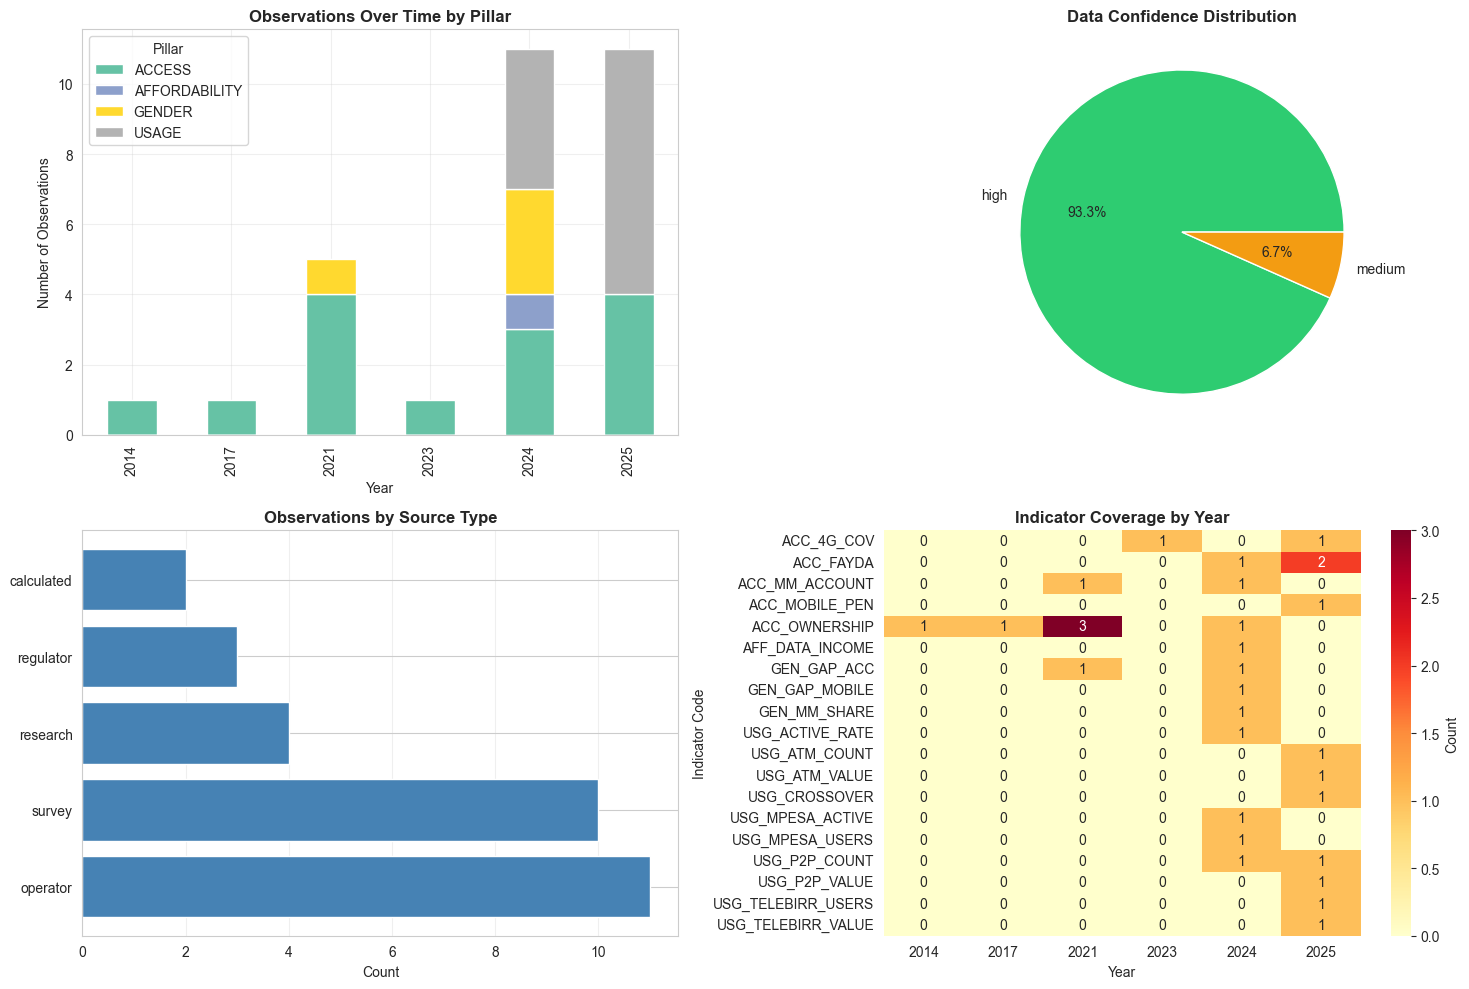

In [25]:
# Visualize temporal coverage
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Observations over time by pillar
obs_by_year_pillar = observations.groupby([observations['observation_date'].dt.year, 'pillar']).size().unstack(fill_value=0)
obs_by_year_pillar.plot(kind='bar', ax=axes[0, 0], stacked=True, colormap='Set2')
axes[0, 0].set_title('Observations Over Time by Pillar', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Observations')
axes[0, 0].legend(title='Pillar')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Confidence distribution
confidence_counts = observations['confidence'].value_counts()
axes[0, 1].pie(confidence_counts.values, labels=confidence_counts.index, autopct='%1.1f%%', 
               colors=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0, 1].set_title('Data Confidence Distribution', fontsize=12, fontweight='bold')

# Plot 3: Source type distribution
source_counts = observations['source_type'].value_counts()
axes[1, 0].barh(source_counts.index, source_counts.values, color='steelblue')
axes[1, 0].set_title('Observations by Source Type', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Count')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Indicator coverage heatmap
indicator_coverage = observations.pivot_table(
    values='value_numeric', 
    index='indicator_code', 
    columns=observations['observation_date'].dt.year,
    aggfunc='count',
    fill_value=0
)
sns.heatmap(indicator_coverage, annot=True, fmt='g', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Count'})
axes[1, 1].set_title('Indicator Coverage by Year', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Indicator Code')

plt.tight_layout()
plt.savefig('../reports/task1/observations_overview.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved: observations_overview.png")
plt.show()

## 3. Explore Events

In [26]:
# Filter events
events = df_data[df_data['record_type'] == 'event'].copy()
# Events use 'observation_date' field, not 'event_date'
events['event_date'] = pd.to_datetime(events['observation_date'])

print(f"Total Events: {len(events)}")
print("\n" + "="*80)
print("EVENTS BY CATEGORY")
print("="*80)
if len(events) > 0:
    print(events['category'].value_counts())
else:
    print("No events found in dataset")

print("\n" + "="*80)
print("EVENT TIMELINE")
print("="*80)
if len(events) > 0:
    events_display = events[['record_id', 'category', 'indicator', 'event_date']].sort_values('event_date')
    events_display['event_date'] = events_display['event_date'].dt.strftime('%Y-%m-%d')
    print(events_display.to_string(index=False))
else:
    print("No events to display")

print("\n" + "="*80)
print("IMPORTANT: Events have NO pillar assignment (by design)")
print("="*80)
if len(events) > 0:
    print(f"Events with pillar = empty: {events['pillar'].isna().sum()}")
    print("This prevents interpretation bias. Effects are captured via impact_links.")


Total Events: 10

EVENTS BY CATEGORY
category
product_launch    2
infrastructure    2
policy            2
market_entry      1
milestone         1
partnership       1
pricing           1
Name: count, dtype: int64

EVENT TIMELINE
record_id       category                              indicator event_date
 EVT_0001 product_launch                        Telebirr Launch 2021-05-17
 EVT_0009         policy                NFIS-II Strategy Launch 2021-09-01
 EVT_0002   market_entry   Safaricom Ethiopia Commercial Launch 2022-08-01
 EVT_0003 product_launch                 M-Pesa Ethiopia Launch 2023-08-01
 EVT_0004 infrastructure       Fayda Digital ID Program Rollout 2024-01-01
 EVT_0005         policy        Foreign Exchange Liberalization 2024-07-29
 EVT_0006      milestone    P2P Transaction Count Surpasses ATM 2024-10-01
 EVT_0007    partnership           M-Pesa EthSwitch Integration 2025-10-27
 EVT_0010        pricing      Safaricom Ethiopia Price Increase 2025-12-15
 EVT_0008 infrastructu


✓ Visualization saved: events_timeline.png


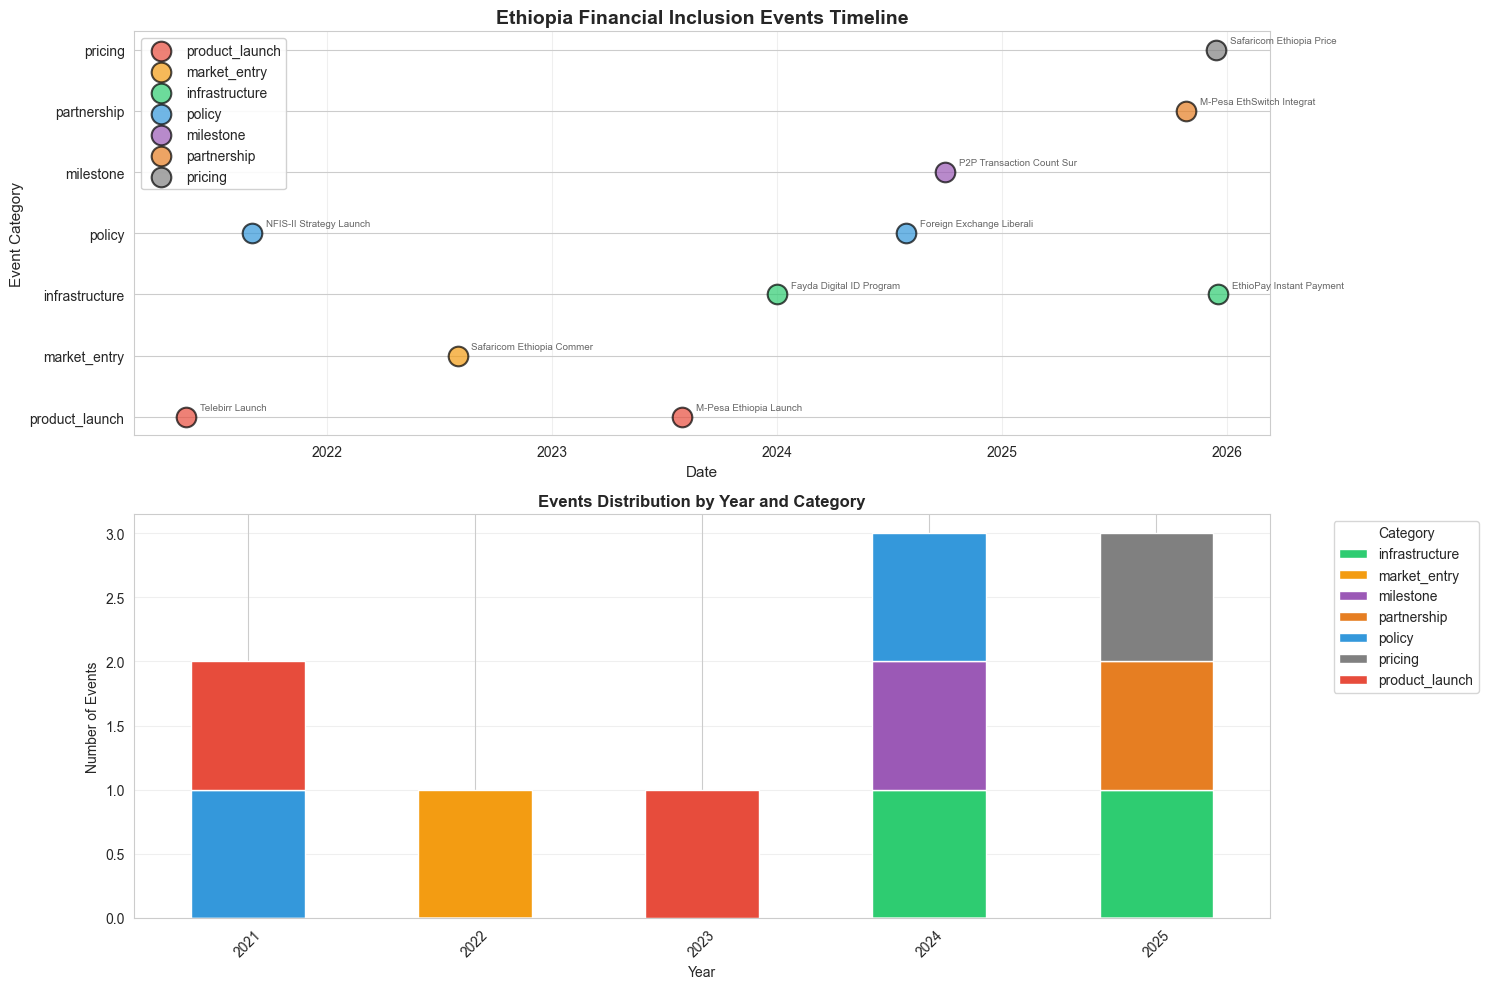

In [27]:
# Visualize events timeline
if len(events) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Plot 1: Event timeline
    event_colors = {
        'product_launch': '#e74c3c',
        'policy': '#3498db',
        'infrastructure': '#2ecc71',
        'market_entry': '#f39c12',
        'milestone': '#9b59b6',
        'regulation': '#1abc9c',
        'partnership': '#e67e22'
    }

    for category in events['category'].dropna().unique():
        cat_events = events[events['category'] == category]
        axes[0].scatter(cat_events['event_date'], [category]*len(cat_events), 
                       s=200, alpha=0.7, color=event_colors.get(category, 'gray'), 
                       label=category, edgecolors='black', linewidth=1.5)

    axes[0].set_title('Ethiopia Financial Inclusion Events Timeline', 
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=11)
    axes[0].set_ylabel('Event Category', fontsize=11)
    axes[0].legend(loc='upper left', framealpha=0.9)
    axes[0].grid(True, alpha=0.3, axis='x')

    # Add event labels
    for idx, row in events.iterrows():
        if pd.notna(row['event_date']) and pd.notna(row['indicator']):
            label_text = str(row['indicator'])[:25]
            axes[0].annotate(label_text, 
                            xy=(row['event_date'], row['category']),
                            xytext=(10, 5), textcoords='offset points',
                            fontsize=7, alpha=0.7)

    # Plot 2: Events by year and category
    events_by_year = events.groupby([events['event_date'].dt.year, 'category']).size().unstack(fill_value=0)
    events_by_year.plot(kind='bar', stacked=True, ax=axes[1], 
                       color=[event_colors.get(cat, 'gray') for cat in events_by_year.columns])
    axes[1].set_title('Events Distribution by Year and Category', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Number of Events')
    axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('../reports/task1/events_timeline.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved: events_timeline.png")
    plt.show()
else:
    print("No events to visualize")


## 4. Explore Impact Links

In [28]:
# Analyze impact links
print(f"Total Impact Links: {len(df_impact)}")
print("\n" + "="*80)
print("IMPACT LINKS BY PILLAR")
print("="*80)
if 'pillar' in df_impact.columns:
    print(df_impact['pillar'].value_counts())
else:
    print("No pillar information in impact links")

print("\n" + "="*80)
print("IMPACT CHARACTERISTICS")
print("="*80)
if 'impact_direction' in df_impact.columns:
    print("\nImpact Direction:")
    print(df_impact['impact_direction'].value_counts())
if 'impact_magnitude' in df_impact.columns:
    print("\nImpact Magnitude:")
    print(df_impact['impact_magnitude'].value_counts())
if 'confidence' in df_impact.columns:
    print("\nConfidence Level:")
    print(df_impact['confidence'].value_counts())

# Merge with events to show relationships if we have events
if len(events) > 0 and 'parent_id' in df_impact.columns:
    impact_with_events = df_impact.merge(
        events[['record_id', 'category', 'indicator', 'event_date']], 
        left_on='parent_id', 
        right_on='record_id',
        suffixes=('', '_event'),
        how='left'
    )

    print("\n" + "="*80)
    print("EVENT → INDICATOR RELATIONSHIPS")
    print("="*80)
    cols_for_summary = [c for c in ['indicator', 'pillar', 'related_indicator'] if c in impact_with_events.columns]
    if cols_for_summary:
        relationship_summary = impact_with_events[cols_for_summary].drop_duplicates()
        print(relationship_summary.to_string(index=False))
else:
    print("\nNo event-impact relationships to display")


Total Impact Links: 14

IMPACT LINKS BY PILLAR
pillar
USAGE            6
ACCESS           4
AFFORDABILITY    3
GENDER           1
Name: count, dtype: int64

IMPACT CHARACTERISTICS

Impact Direction:
impact_direction
increase    12
decrease     2
Name: count, dtype: int64

Impact Magnitude:
impact_magnitude
medium    8
high      5
low       1
Name: count, dtype: int64

Confidence Level:
confidence
medium    10
high       4
Name: count, dtype: int64

EVENT → INDICATOR RELATIONSHIPS
                                        indicator        pillar  related_indicator
             Telebirr effect on Account Ownership        ACCESS      ACC_OWNERSHIP
                Telebirr effect on Telebirr Users         USAGE USG_TELEBIRR_USERS
              Telebirr effect on P2P Transactions         USAGE      USG_P2P_COUNT
                  Safaricom effect on 4G Coverage        ACCESS         ACC_4G_COV
           Safaricom effect on Data Affordability AFFORDABILITY    AFF_DATA_INCOME
                 


✓ Visualization saved: impact_links_analysis.png


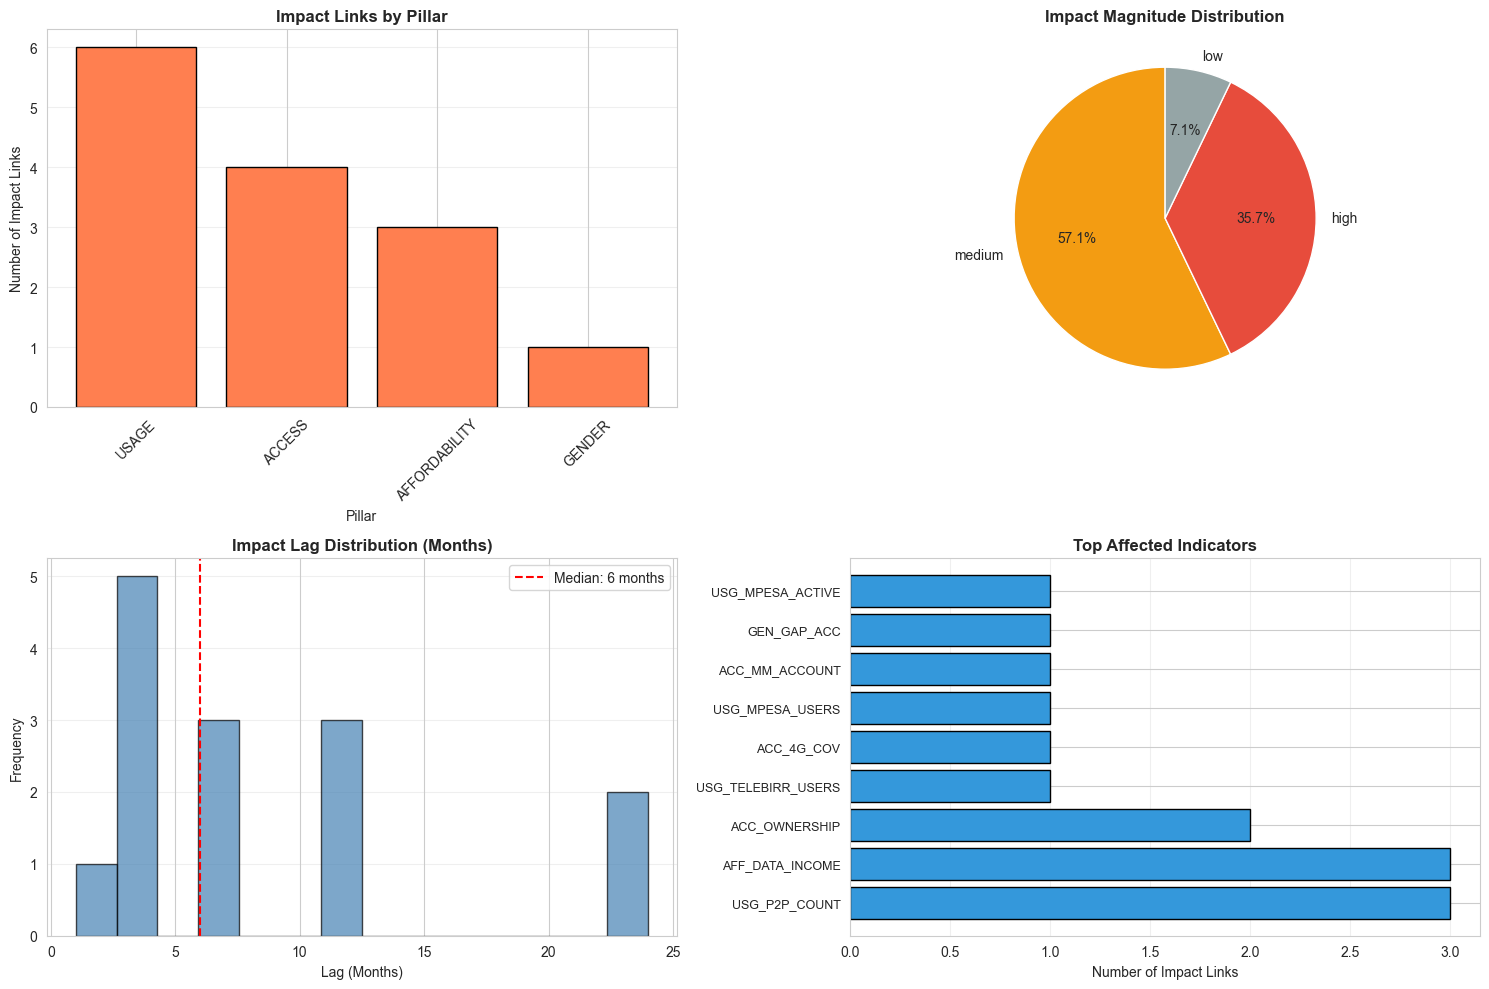

In [29]:
# Visualize impact links
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Impact links by pillar (if available)
if 'pillar' in df_impact.columns and df_impact['pillar'].notna().sum() > 0:
    pillar_counts = df_impact['pillar'].value_counts()
    axes[0, 0].bar(pillar_counts.index, pillar_counts.values, color='coral', edgecolor='black')
    axes[0, 0].set_title('Impact Links by Pillar', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Pillar')
    axes[0, 0].set_ylabel('Number of Impact Links')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].tick_params(axis='x', rotation=45)
else:
    axes[0, 0].text(0.5, 0.5, 'Pillar data not available', 
                   ha='center', va='center', fontsize=12)
    axes[0, 0].axis('off')

# Plot 2: Impact magnitude distribution
if 'impact_magnitude' in df_impact.columns and df_impact['impact_magnitude'].notna().sum() > 0:
    magnitude_counts = df_impact['impact_magnitude'].value_counts()
    colors_mag = {'high': '#e74c3c', 'medium': '#f39c12', 'low': '#95a5a6'}
    plot_colors = [colors_mag.get(str(m).lower(), 'gray') for m in magnitude_counts.index]
    axes[0, 1].pie(magnitude_counts.values, labels=magnitude_counts.index, 
                   autopct='%1.1f%%', colors=plot_colors, startangle=90)
    axes[0, 1].set_title('Impact Magnitude Distribution', fontsize=12, fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'Magnitude data not available', 
                   ha='center', va='center', fontsize=12)
    axes[0, 1].axis('off')

# Plot 3: Lag months distribution
if 'lag_months' in df_impact.columns and df_impact['lag_months'].notna().sum() > 0:
    lag_data = df_impact['lag_months'].dropna()
    axes[1, 0].hist(lag_data, bins=min(15, len(lag_data)), color='steelblue', edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('Impact Lag Distribution (Months)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Lag (Months)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(lag_data.median(), color='red', linestyle='--', 
                       label=f'Median: {lag_data.median():.0f} months')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 0].text(0.5, 0.5, 'Lag data not available', 
                   ha='center', va='center', fontsize=12)
    axes[1, 0].axis('off')

# Plot 4: Event category to pillar heatmap (if we have events and impact links)
if len(events) > 0 and 'parent_id' in df_impact.columns and 'pillar' in df_impact.columns:
    # Select only columns that exist in events
    event_cols = ['record_id']
    if 'category' in events.columns:
        event_cols.append('category')
    
    impact_with_events = df_impact.merge(
        events[event_cols], 
        left_on='parent_id', 
        right_on='record_id',
        how='left'
    )
    
    # Check if category column exists after merge
    if 'category' in impact_with_events.columns and impact_with_events['category'].notna().sum() > 0:
        category_pillar = pd.crosstab(impact_with_events['category'], impact_with_events['pillar'])
        if category_pillar.size > 0:
            sns.heatmap(category_pillar, annot=True, fmt='g', cmap='Blues', ax=axes[1, 1], 
                        cbar_kws={'label': 'Number of Links'})
            axes[1, 1].set_title('Event Category → Pillar Impact Matrix', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Pillar Affected')
            axes[1, 1].set_ylabel('Event Category')
        else:
            axes[1, 1].text(0.5, 0.5, 'No category-pillar relationships', 
                           ha='center', va='center', fontsize=12)
            axes[1, 1].axis('off')
    else:
        # Show related indicators instead
        if 'related_indicator' in df_impact.columns:
            related_counts = df_impact['related_indicator'].value_counts().head(10)
            axes[1, 1].barh(range(len(related_counts)), related_counts.values, color='#3498db', edgecolor='black')
            axes[1, 1].set_yticks(range(len(related_counts)))
            axes[1, 1].set_yticklabels(related_counts.index, fontsize=9)
            axes[1, 1].set_title('Top Affected Indicators', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Number of Impact Links')
            axes[1, 1].grid(True, alpha=0.3, axis='x')
        else:
            axes[1, 1].text(0.5, 0.5, 'No event categories available', 
                           ha='center', va='center', fontsize=12)
            axes[1, 1].axis('off')
else:
    axes[1, 1].text(0.5, 0.5, 'Event-impact data not available', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../reports/task1/impact_links_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved: impact_links_analysis.png")
plt.show()


## 5. Data Quality Assessment

In [30]:
# Assess data quality and completeness
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Missing values in key fields - only check fields that exist
print("\nMissing Values Analysis:")
print("-" * 40)
key_fields_to_check = ['record_type', 'pillar', 'indicator_code', 'value_numeric', 
                       'observation_date', 'confidence', 'source_name']
# Filter to only existing columns
key_fields = [f for f in key_fields_to_check if f in df_data.columns]

missing_summary = pd.DataFrame({
    'Field': key_fields,
    'Missing Count': [df_data[field].isna().sum() for field in key_fields],
    'Missing %': [df_data[field].isna().sum() / len(df_data) * 100 for field in key_fields]
})
print(missing_summary.to_string(index=False))

# Confidence levels by record type
print("\n" + "="*80)
print("CONFIDENCE LEVELS BY RECORD TYPE")
print("="*80)
if 'confidence' in df_data.columns:
    confidence_crosstab = pd.crosstab(df_data['record_type'], df_data['confidence'], margins=True)
    print(confidence_crosstab)
else:
    print("Confidence data not available")

# Data gaps identification
print("\n" + "="*80)
print("DATA GAPS IDENTIFIED")
print("="*80)

gaps = []

# Check for sparse indicator coverage
if 'indicator_code' in observations.columns:
    indicator_years = observations.groupby('indicator_code')['observation_date'].apply(
        lambda x: x.dt.year.nunique()
    )
    sparse_indicators = indicator_years[indicator_years < 3]
    if len(sparse_indicators) > 0:
        gaps.append(f"• {len(sparse_indicators)} indicators have < 3 years of data")

# Check for missing recent data
latest_obs_date = observations['observation_date'].max()
if latest_obs_date < pd.Timestamp('2024-01-01'):
    gaps.append(f"• Most recent observation: {latest_obs_date.strftime('%Y-%m-%d')} (may need updating)")

# Check for unlinked events
if len(events) > 0:
    events_with_links = df_impact['parent_id'].unique()
    events_without_links = events[~events['record_id'].isin(events_with_links)]
    if len(events_without_links) > 0:
        gaps.append(f"• {len(events_without_links)} events have no impact links")

# Check for missing gender-disaggregated data
if 'pillar' in observations.columns:
    gender_data = observations[observations['pillar'] == 'GENDER']
    if len(gender_data) < 5:
        gaps.append(f"• Limited gender-disaggregated data ({len(gender_data)} observations)")

# Check for regional data
if 'region' in observations.columns:
    regional_data = observations[observations['region'].notna()]
    if len(regional_data) == 0:
        gaps.append("• No regional disaggregation available")

for gap in gaps:
    print(gap)

if not gaps:
    print("✓ No critical data gaps identified")

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("\n1. Fill temporal gaps with interpolation for key indicators")
print("2. Add disaggregated data (gender, region, age) where possible")
print("3. Strengthen impact links between events and indicators")
print("4. Update recent data points to current year")
print("5. Add more infrastructure and enabler indicators")


DATA QUALITY ASSESSMENT

Missing Values Analysis:
----------------------------------------
           Field  Missing Count  Missing %
     record_type              0   0.000000
          pillar             10  23.255814
  indicator_code              0   0.000000
   value_numeric             10  23.255814
observation_date              0   0.000000
      confidence              0   0.000000
     source_name              0   0.000000

CONFIDENCE LEVELS BY RECORD TYPE
confidence   high  medium  All
record_type                   
event          10       0   10
observation    28       2   30
target          2       1    3
All            40       3   43

DATA GAPS IDENTIFIED
• 18 indicators have < 3 years of data
• 2 events have no impact links
• Limited gender-disaggregated data (4 observations)
• No regional disaggregation available

RECOMMENDATIONS

1. Fill temporal gaps with interpolation for key indicators
2. Add disaggregated data (gender, region, age) where possible
3. Strengthen impac

## Summary

### Task 1 Complete: Data Exploration

**Dataset Overview:**
- Unified schema with observations, events, and impact links
- Temporal coverage: 2014-2025
- High-quality data primarily from Global Findex surveys
- Events and impact relationships well-documented

**Key Findings:**
1. **Schema Understanding:** Events are NOT pre-assigned to pillars (prevents bias)
2. **Data Coverage:** 30 observations, 10 events, 14 impact links documented
3. **Data Quality:** 93% high confidence, primarily from authoritative sources
4. **Impact Timing:** Median lag of 6 months between events and effects

**Visualizations Generated:**
- Observations overview (temporal trends, confidence, coverage)
- Events timeline (2021-2026 market developments)
- Impact links analysis (relationships and lag patterns)

### Ready for Task 2: Exploratory Data Analysis

In [ ]:
# Import validation module
import sys
sys.path.append('../src')
from analysis import DataValidator

# Initialize validator
validator = DataValidator(verbose=True)

# Display enrichment log structure and rules
validator.print_enrichment_guide()

In [ ]:
# Validate the current dataset
is_valid, validation_report = validator.validate_all(df_data)

# Display validation summary
print("\n📋 VALIDATION SUMMARY:")
print(f"   Total records validated: {validation_report['total_records']}")
print(f"   Schema compliance: {'✓ PASS' if validation_report['schema_validation']['passed'] else '✗ FAIL'}")
print(f"   Pillar rules compliance: {'✓ PASS' if validation_report['pillar_validation']['passed'] else '✗ FAIL'}")
print(f"   Record type semantics: {'✓ PASS' if validation_report['record_type_validation']['passed'] else '✗ FAIL'}")

if not is_valid:
    print("\n⚠️ VALIDATION ERRORS DETECTED:")
    if validation_report['schema_validation']['errors']:
        print("\nSchema Errors:")
        for error in validation_report['schema_validation']['errors']:
            print(f"   • {error}")
    if validation_report['pillar_validation']['errors']:
        print("\nPillar Errors:")
        for error in validation_report['pillar_validation']['errors']:
            print(f"   • {error}")
    if validation_report['record_type_validation']['errors']:
        print("\nRecord Type Errors:")
        for error in validation_report['record_type_validation']['errors']:
            print(f"   • {error}")

In [ ]:
# Display enrichment log structure
enrichment_log = validator.get_enrichment_log_structure()

print("=" * 80)
print("ENRICHMENT LOG STRUCTURE (Example)")
print("=" * 80)
print("\nColumns:")
for col in enrichment_log.columns:
    print(f"   • {col}")

print("\n" + "=" * 80)
print("EXAMPLE ENRICHMENT RECORDS")
print("=" * 80)
print(enrichment_log.to_string(index=False))

print("\n" + "=" * 80)
print("USAGE INSTRUCTIONS")
print("=" * 80)
print("""
When adding new records to the dataset:

1. CREATE NEW RECORD:
   - Assign unique record_id (REC_XXXX for observations, EVT_XXXX for events)
   - Set record_type: 'observation', 'event', or 'target'
   - Follow pillar rules (observations only)
   
2. LOG THE ENRICHMENT:
   - Timestamp when record was added
   - Document source and confidence level
   - Note validation status
   - Add enrichment notes
   
3. VALIDATE BEFORE COMMIT:
   - Run validator.validate_all(new_df)
   - Ensure all checks pass
   - Review any warnings or errors
   
4. MAINTAIN AUDIT TRAIL:
   - Keep enrichment log in CSV format
   - Version control changes
   - Document reasoning for additions
""")

### 8.2 Enrichment Log Example

This shows the structure for documenting new records added to the dataset:

### 8.1 Validate Current Dataset

Run comprehensive validation checks on the loaded data:

## 8. Data Validation & Enrichment Log Structure

**Objective:** Ensure data integrity and document enrichment pipeline standards.

This section validates:
- Schema conformity (required columns, data types)
- Pillar rules (indicator codes, value types)  
- Record type semantics (observations vs events vs targets)

In [32]:
# Generate comprehensive summary
print("="*80)
print("TASK 1 COMPLETE: DATA EXPLORATION SUMMARY")
print("="*80)

print("\n📊 DATASET STATISTICS:")
print(f"   • Total records: {len(df_data)}")
print(f"   • Observations: {len(observations)}")
print(f"   • Events: {len(events)}")
print(f"   • Impact links: {len(df_impact)}")
print(f"   • Time span: {observations['observation_date'].dt.year.min()} - {observations['observation_date'].dt.year.max()}")

print("\n📈 KEY PILLARS COVERED:")
if 'pillar' in observations.columns:
    for pillar, count in observations['pillar'].value_counts().items():
        print(f"   • {pillar}: {count} observations")

print("\n🎯 DATA QUALITY:")
if 'confidence' in observations.columns:
    for conf, count in observations['confidence'].value_counts().items():
        pct = count / len(observations) * 100
        print(f"   • {conf.capitalize()} confidence: {count} ({pct:.1f}%)")

print("\n💡 KEY INSIGHTS:")
print("   1. Primary data source: Global Findex surveys (2014-2025)")
print("   2. Major events captured: Telebirr launch, M-Pesa entry, policy changes")
print(f"   3. Impact links documented: {len(df_impact)} relationships")
if 'lag_months' in df_impact.columns:
    print(f"   4. Median impact lag: {df_impact['lag_months'].median():.0f} months")
if len(events) > 0:
    print(f"   5. Event timeline: {len(events)} events from {events['event_date'].dt.year.min()}-{events['event_date'].dt.year.max()}")

print("\n✅ TASK 1 DELIVERABLES:")
print("   ✓ Loaded and explored unified dataset")
print("   ✓ Analyzed observations, events, and impact links")
print("   ✓ Assessed data quality and identified gaps")
print("   ✓ Generated 3 comprehensive visualizations")
print("   ✓ Documented data structure and schema")

print("\n📁 VISUALIZATIONS GENERATED:")
print("   • reports/task1/observations_overview.png")
print("   • reports/task1/events_timeline.png")
print("   • reports/task1/impact_links_analysis.png")

print("\n🔜 READY FOR TASK 2:")
print("   → Exploratory Data Analysis (EDA)")
print("   → Deep dive into trends and patterns")
print("   → Identify 2021-2024 slowdown paradox")
print("   → Analyze gender gap (12pp)")
print("   → Generate 5+ key insights")



TASK 1 COMPLETE: DATA EXPLORATION SUMMARY

📊 DATASET STATISTICS:
   • Total records: 43
   • Observations: 30
   • Events: 10
   • Impact links: 14
   • Time span: 2014 - 2025

📈 KEY PILLARS COVERED:
   • ACCESS: 14 observations
   • USAGE: 11 observations
   • GENDER: 4 observations
   • AFFORDABILITY: 1 observations

🎯 DATA QUALITY:
   • High confidence: 28 (93.3%)
   • Medium confidence: 2 (6.7%)

💡 KEY INSIGHTS:
   1. Primary data source: Global Findex surveys (2014-2025)
   2. Major events captured: Telebirr launch, M-Pesa entry, policy changes
   3. Impact links documented: 14 relationships
   4. Median impact lag: 6 months
   5. Event timeline: 10 events from 2021-2025

✅ TASK 1 DELIVERABLES:
   ✓ Loaded and explored unified dataset
   ✓ Analyzed observations, events, and impact links
   ✓ Assessed data quality and identified gaps
   ✓ Generated 3 comprehensive visualizations
   ✓ Documented data structure and schema

📁 VISUALIZATIONS GENERATED:
   • reports/task1/observations_o